In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
from datasets import load_from_disk

In [3]:
sys.path.append("/mnt/storage2/arafat_shovon/flow_matching_and_llm/notebooks")

In [4]:
from transformers import(
    Blip2ForConditionalGeneration,
    Blip2Processor
)

**Load the Model**

In [5]:
model_name = "Salesforce/blip2-opt-2.7b"

processor = Blip2Processor.from_pretrained(model_name, 
                                        cache_dir="../data/cache")

model = Blip2ForConditionalGeneration.from_pretrained(model_name,
                                                    torch_dtype=torch.float16,
                                                    cache_dir="../data/cache",
                                                    device_map="auto")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**Load the Dataset**

In [6]:
data = load_from_disk("../data/flickr8k/train")

**GradCam Class**

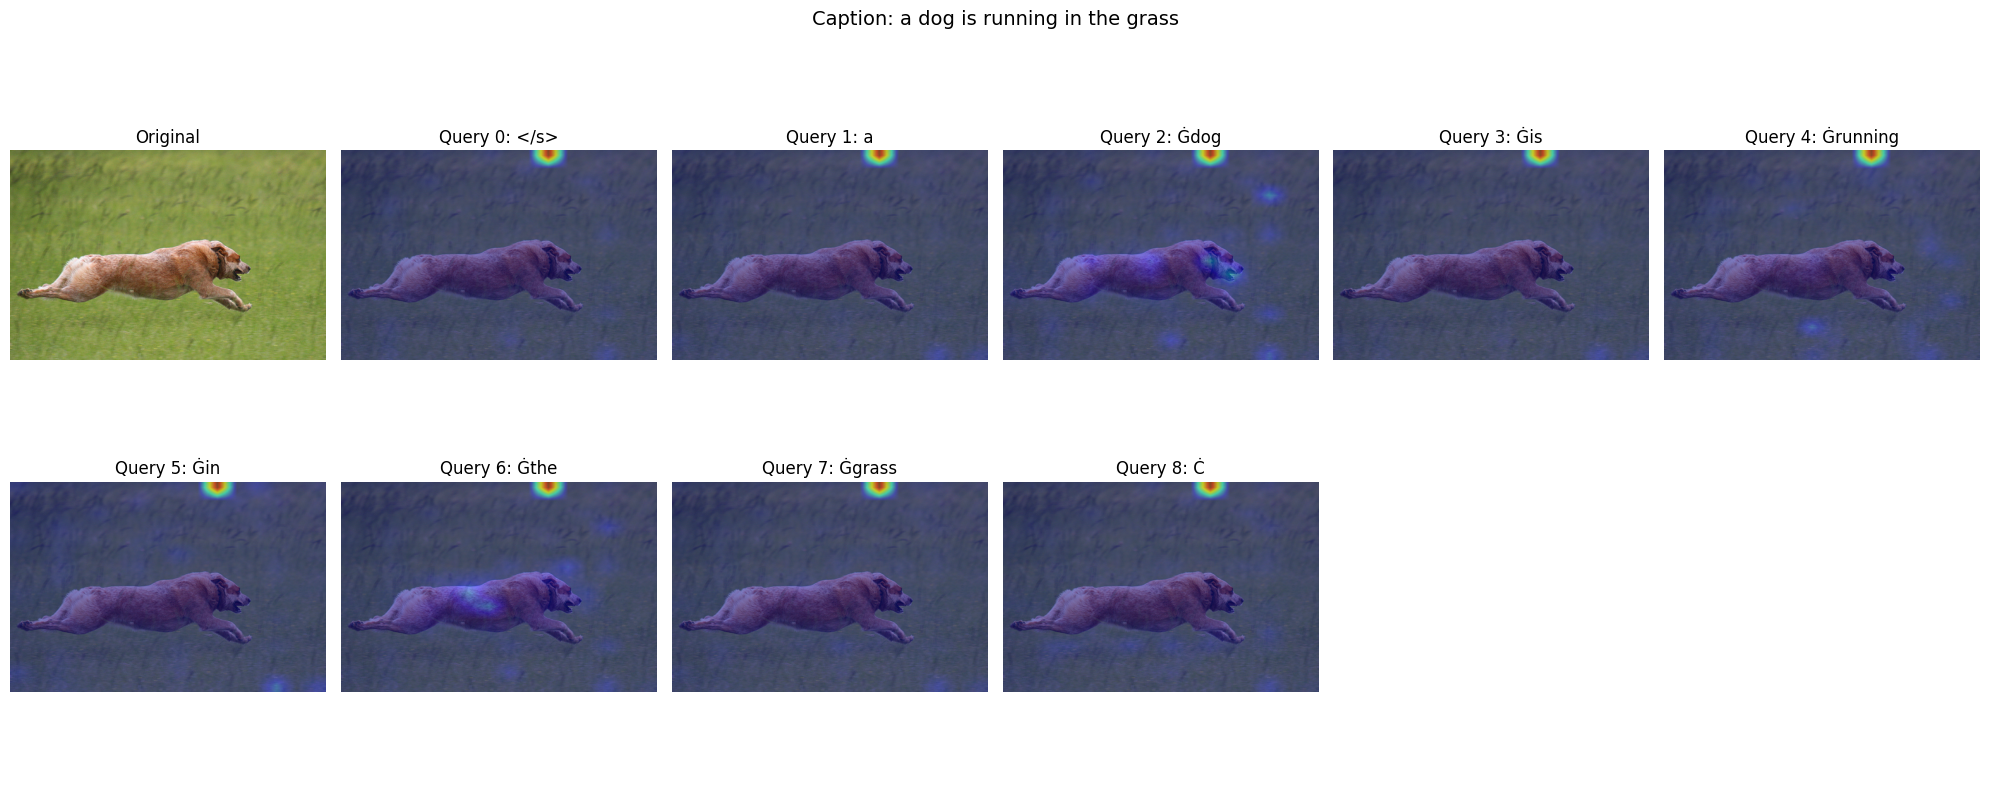

([array([[0.0018106 , 0.0018106 , 0.0018106 , ..., 0.0009087 , 0.0009087 ,
          0.0009087 ],
         [0.0018106 , 0.0018106 , 0.0018106 , ..., 0.0009087 , 0.0009087 ,
          0.0009087 ],
         [0.0018106 , 0.0018106 , 0.0018106 , ..., 0.0009087 , 0.0009087 ,
          0.0009087 ],
         ...,
         [0.00273481, 0.00273481, 0.00273481, ..., 0.01369144, 0.01369144,
          0.01369144],
         [0.00273481, 0.00273481, 0.00273481, ..., 0.01369144, 0.01369144,
          0.01369144],
         [0.00273481, 0.00273481, 0.00273481, ..., 0.01369144, 0.01369144,
          0.01369144]], shape=(333, 500), dtype=float32),
  array([[0.01647106, 0.01647106, 0.01647106, ..., 0.01078967, 0.01078967,
          0.01078967],
         [0.01647106, 0.01647106, 0.01647106, ..., 0.01078967, 0.01078967,
          0.01078967],
         [0.01647106, 0.01647106, 0.01647106, ..., 0.01078967, 0.01078967,
          0.01078967],
         ...,
         [0.01271261, 0.01271261, 0.01271261, ..., 0.07

In [16]:
class Blip2PerTokenAttention:
    """
    Generate attention maps for each token in the caption.
    Shows what image regions are attended to for each word.
    """
    
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.device = next(model.parameters()).device
    
    def get_per_token_attention(self, image, caption=None):
        """
        Get attention map for each token in the caption.
        
        Returns:
            attention_maps: List of attention maps, one per token
            tokens: List of token strings
        """
        orig_size = image.size
        
        # Generate caption if not provided
        if caption is None:
            inputs = self.processor(images=image, return_tensors="pt").to(self.device)
            with torch.no_grad():
                generated_ids = self.model.generate(**inputs, max_new_tokens=50)
            caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
        
        # Tokenize caption
        text_inputs = self.processor.tokenizer(caption, return_tensors="pt").to(self.device)
        tokens = self.processor.tokenizer.convert_ids_to_tokens(text_inputs.input_ids[0])
        
        # Get vision features
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            vision_outputs = self.model.vision_model(
                inputs['pixel_values'],
                output_attentions=True,
                return_dict=True
            )
            image_embeds = vision_outputs.last_hidden_state
            image_attn_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(self.device)
            
            query_tokens = self.model.query_tokens.expand(image_embeds.shape[0], -1, -1)
            
            qformer_outputs = self.model.qformer(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_attn_mask,
                output_attentions=True,
                return_dict=True
            )
        
        # Get cross-attention from all layers and average
        # [batch, heads, queries, image_tokens]
        cross_attn = torch.stack(qformer_outputs.cross_attentions).mean(dim=0)
        
        # For per-token: use each query's attention
        # Assuming queries correspond to different aspects
        # Average over heads: [batch, queries, image_tokens]
        cross_attn = cross_attn.mean(dim=1)[0]  # [queries, image_tokens]
        
        # Remove CLS from image tokens
        cross_attn = cross_attn[:, 1:]  # [queries, 256]
        
        grid_size = int(np.sqrt(cross_attn.shape[1]))
        
        attention_maps = []
        num_queries = min(cross_attn.shape[0], len(tokens))
        
        for i in range(num_queries):
            attn = cross_attn[i].reshape(grid_size, grid_size)
            attn = attn - attn.min()
            if attn.max() > 0:
                attn = attn / attn.max()
            attn = attn.cpu().float().numpy()
            attn = cv2.resize(attn, orig_size)
            attention_maps.append(attn)
        
        return attention_maps, tokens[:num_queries], caption
    
    def visualize_per_token(self, image, max_tokens=10):
        """Visualize attention for each token."""
        attention_maps, tokens, caption = self.get_per_token_attention(image)
        
        img_np = np.array(image)
        n_maps = min(len(attention_maps), max_tokens)
        
        fig, axes = plt.subplots(2, (n_maps + 1) // 2 + 1, figsize=(20, 8))
        axes = axes.flatten()
        
        # Original image
        axes[0].imshow(img_np)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        for i in range(n_maps):
            heatmap = cv2.applyColorMap(np.uint8(255 * attention_maps[i]), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
            overlay = np.uint8(0.5 * heatmap + 0.5 * img_np)
            
            axes[i + 1].imshow(overlay)
            axes[i + 1].set_title(f"Query {i}: {tokens[i] if i < len(tokens) else ''}")
            axes[i + 1].axis('off')
        
        # Hide unused axes
        for j in range(n_maps + 1, len(axes)):
            axes[j].axis('off')
        
        fig.suptitle(f"Caption: {caption}", fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return attention_maps, tokens


image = data[210]['image']
per_token = Blip2PerTokenAttention(model, processor)
per_token.visualize_per_token(image)

In [ ]:
"""
BLIP2 Attention Map Extraction - Multiple Methods
==================================================
This module provides several methods to extract meaningful attention maps from BLIP2.

Methods:
1. Grad-CAM on Vision Encoder
2. Gradient-Weighted Q-Former Cross-Attention
3. Text-Guided Attention (for specific words)
4. Attention Rollout

Author: Claude
"""

import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from typing import Optional, Tuple, List, Dict
from transformers import Blip2Processor, Blip2ForConditionalGeneration


class Blip2AttentionExtractor:
    """
    Extract meaningful attention maps from BLIP2 model.
    Supports multiple extraction methods for best results.
    """
    
    def __init__(
        self, 
        model_name: str = "Salesforce/blip2-opt-2.7b",
        device: str = None,
        load_in_8bit: bool = False
    ):
        """
        Initialize the attention extractor.
        
        Args:
            model_name: HuggingFace model name
            device: Device to use (auto-detected if None)
            load_in_8bit: Whether to load in 8-bit quantization
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        
        print(f"Loading model: {model_name}")
        self.processor = Blip2Processor.from_pretrained(model_name)
        
        if load_in_8bit:
            from transformers import BitsAndBytesConfig
            bnb_config = BitsAndBytesConfig(load_in_8bit=True)
            self.model = Blip2ForConditionalGeneration.from_pretrained(
                model_name,
                quantization_config=bnb_config,
                device_map="auto"
            )
        else:
            self.model = Blip2ForConditionalGeneration.from_pretrained(model_name)
            self.model.to(self.device)
        
        self.model.eval()
        
        # Store hooks for Grad-CAM
        self.activations = {}
        self.gradients = {}
        
        print(f"Model loaded on {self.device}")
    
    def _register_hooks(self, layer_name: str = "vision_model"):
        """Register forward and backward hooks for Grad-CAM."""
        
        def forward_hook(module, input, output):
            if isinstance(output, tuple):
                self.activations[layer_name] = output[0].detach()
            else:
                self.activations[layer_name] = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            if isinstance(grad_output, tuple):
                self.gradients[layer_name] = grad_output[0].detach()
            else:
                self.gradients[layer_name] = grad_output.detach()
        
        # Get the last encoder layer of vision model
        target_layer = self.model.vision_model.encoder.layers[-1]
        
        forward_handle = target_layer.register_forward_hook(forward_hook)
        backward_handle = target_layer.register_full_backward_hook(backward_hook)
        
        return forward_handle, backward_handle
    
    def _preprocess_image(self, image: Image.Image) -> Tuple[torch.Tensor, Tuple[int, int]]:
        """Preprocess image and return tensor with original size."""
        orig_size = image.size  # (width, height)
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(self.device)
        return pixel_values, orig_size
    
    def _postprocess_attention(
        self, 
        attn_map: np.ndarray, 
        orig_size: Tuple[int, int],
        smooth: bool = True
    ) -> np.ndarray:
        """Postprocess attention map: normalize and resize."""
        # Normalize to [0, 1]
        attn_map = attn_map - attn_map.min()
        if attn_map.max() > 0:
            attn_map = attn_map / attn_map.max()
        
        # Resize to original image size
        attn_map = cv2.resize(attn_map, orig_size)
        
        # Optional smoothing
        if smooth:
            attn_map = cv2.GaussianBlur(attn_map, (5, 5), 0)
            # Re-normalize after blur
            attn_map = attn_map - attn_map.min()
            if attn_map.max() > 0:
                attn_map = attn_map / attn_map.max()
        
        return attn_map
    
    # =========================================================================
    # Method 1: Grad-CAM on Vision Encoder
    # =========================================================================
    def gradcam_vision_encoder(
        self, 
        image: Image.Image, 
        text: Optional[str] = None
    ) -> Tuple[np.ndarray, str]:
        """
        Generate Grad-CAM attention map using vision encoder activations.
        
        This method uses gradients from the language model loss to weight
        the vision encoder activations, highlighting regions important for
        caption generation.
        
        Args:
            image: Input PIL Image
            text: Optional text prompt (if None, generates caption first)
            
        Returns:
            attention_map: Normalized attention map as numpy array
            caption: Generated or provided caption
        """
        pixel_values, orig_size = self._preprocess_image(image)
        
        # Register hooks
        forward_handle, backward_handle = self._register_hooks()
        
        try:
            # Generate caption if not provided
            with torch.no_grad():
                generated_ids = self.model.generate(
                    pixel_values=pixel_values,
                    max_new_tokens=50
                )
            caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
            
            # Enable gradients
            pixel_values.requires_grad = True
            for param in self.model.vision_model.parameters():
                param.requires_grad = True
            
            # Forward pass with the generated caption as target
            inputs = self.processor(
                images=image, 
                text=caption, 
                return_tensors="pt"
            ).to(self.device)
            
            # Forward pass through vision model
            vision_outputs = self.model.vision_model(
                pixel_values=pixel_values,
                output_attentions=True,
                return_dict=True
            )
            
            image_embeds = vision_outputs.last_hidden_state
            image_attn_mask = torch.ones(
                image_embeds.size()[:-1], 
                dtype=torch.long, 
                device=self.device
            )
            
            # Q-Former
            query_tokens = self.model.query_tokens.expand(image_embeds.shape[0], -1, -1)
            qformer_outputs = self.model.qformer(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_attn_mask,
                return_dict=True
            )
            
            # Language projection
            query_output = qformer_outputs.last_hidden_state
            language_model_inputs = self.model.language_projection(query_output)
            
            # Language model forward with labels
            outputs = self.model.language_model(
                inputs_embeds=language_model_inputs,
                labels=generated_ids,
                return_dict=True
            )
            
            loss = outputs.loss
            
            # Backward pass
            self.model.zero_grad()
            loss.backward()
            
            # Compute Grad-CAM
            activations = self.activations["vision_model"]  # [batch, tokens, hidden]
            gradients = self.gradients["vision_model"]      # [batch, tokens, hidden]
            
            # Global average pooling of gradients
            weights = gradients.mean(dim=-1, keepdim=True)  # [batch, tokens, 1]
            
            # Weighted combination
            cam = (weights * activations).sum(dim=-1)  # [batch, tokens]
            cam = F.relu(cam)  # Only positive contributions
            
            # Remove CLS token and reshape
            cam = cam[0, 1:]  # [num_patches]
            grid_size = int(np.sqrt(cam.shape[0]))
            cam = cam.reshape(grid_size, grid_size)
            
            attn_map = cam.detach().cpu().float().numpy()
            attn_map = self._postprocess_attention(attn_map, orig_size)
            
            return attn_map, caption
            
        finally:
            forward_handle.remove()
            backward_handle.remove()
            # Disable gradients again
            for param in self.model.vision_model.parameters():
                param.requires_grad = False
    
    # =========================================================================
    # Method 2: Gradient-Weighted Q-Former Cross-Attention
    # =========================================================================
    def gradcam_qformer(
        self, 
        image: Image.Image,
        text: Optional[str] = None,
        layer_idx: int = -1
    ) -> Tuple[np.ndarray, str]:
        """
        Generate attention map using gradient-weighted Q-Former cross-attention.
        
        This is often the best method for BLIP2 as Q-Former cross-attention
        directly shows what image regions the model attends to for understanding.
        
        Args:
            image: Input PIL Image
            text: Optional text prompt
            layer_idx: Which Q-Former layer to use (-1 for last)
            
        Returns:
            attention_map: Normalized attention map
            caption: Generated caption
        """
        pixel_values, orig_size = self._preprocess_image(image)
        
        # Generate caption
        with torch.no_grad():
            generated_ids = self.model.generate(
                pixel_values=pixel_values,
                max_new_tokens=50
            )
        caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
        
        # Enable gradients for Q-Former
        for param in self.model.qformer.parameters():
            param.requires_grad = True
        
        try:
            # Vision encoding
            with torch.no_grad():
                vision_outputs = self.model.vision_model(
                    pixel_values=pixel_values,
                    return_dict=True
                )
            image_embeds = vision_outputs.last_hidden_state
            image_embeds.requires_grad = True
            
            image_attn_mask = torch.ones(
                image_embeds.size()[:-1],
                dtype=torch.long,
                device=self.device
            )
            
            # Q-Former with attention output
            query_tokens = self.model.query_tokens.expand(image_embeds.shape[0], -1, -1)
            qformer_outputs = self.model.qformer(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_attn_mask,
                output_attentions=True,
                return_dict=True
            )
            
            # Get cross-attention from specified layer
            cross_attentions = qformer_outputs.cross_attentions
            cross_attn = cross_attentions[layer_idx]  # [batch, heads, queries, image_tokens]
            
            # Language projection and model
            query_output = qformer_outputs.last_hidden_state
            language_model_inputs = self.model.language_projection(query_output)
            
            outputs = self.model.language_model(
                inputs_embeds=language_model_inputs,
                labels=generated_ids,
                return_dict=True
            )
            
            loss = outputs.loss
            
            # Backward
            self.model.zero_grad()
            loss.backward()
            
            # Get attention gradients
            # cross_attn shape: [batch, heads, queries, image_tokens]
            attn_grad = torch.autograd.grad(
                loss, cross_attn, retain_graph=True, allow_unused=True
            )[0]
            
            if attn_grad is not None:
                # Gradient-weighted attention
                weighted_attn = (cross_attn * attn_grad.abs()).mean(dim=(1, 2))  # [batch, image_tokens]
            else:
                # Fallback to raw attention
                weighted_attn = cross_attn.mean(dim=(1, 2))  # [batch, image_tokens]
            
            # Remove CLS token
            attn_map = weighted_attn[0, 1:].detach().cpu().float().numpy()
            
            # Reshape to grid
            grid_size = int(np.sqrt(attn_map.shape[0]))
            attn_map = attn_map.reshape(grid_size, grid_size)
            
            attn_map = self._postprocess_attention(attn_map, orig_size)
            
            return attn_map, caption
            
        finally:
            for param in self.model.qformer.parameters():
                param.requires_grad = False
    
    # =========================================================================
    # Method 3: Aggregated Cross-Attention (No Gradients - Faster)
    # =========================================================================
    def cross_attention_aggregated(
        self, 
        image: Image.Image,
        aggregation: str = "max"
    ) -> Tuple[np.ndarray, str]:
        """
        Extract attention map by aggregating Q-Former cross-attention across layers.
        
        This method doesn't require gradients, making it faster but potentially
        less accurate than gradient-weighted methods.
        
        Args:
            image: Input PIL Image
            aggregation: How to aggregate across layers ("max", "mean", "last")
            
        Returns:
            attention_map: Normalized attention map
            caption: Generated caption
        """
        pixel_values, orig_size = self._preprocess_image(image)
        
        with torch.no_grad():
            # Generate caption
            generated_ids = self.model.generate(
                pixel_values=pixel_values,
                max_new_tokens=50
            )
            caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
            
            # Vision encoding
            vision_outputs = self.model.vision_model(
                pixel_values=pixel_values,
                return_dict=True
            )
            image_embeds = vision_outputs.last_hidden_state
            image_attn_mask = torch.ones(
                image_embeds.size()[:-1],
                dtype=torch.long,
                device=self.device
            )
            
            # Q-Former with attention
            query_tokens = self.model.query_tokens.expand(image_embeds.shape[0], -1, -1)
            qformer_outputs = self.model.qformer(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_attn_mask,
                output_attentions=True,
                return_dict=True
            )
            
            # Stack all cross-attention layers
            # Each: [batch, heads, queries, image_tokens]
            cross_attentions = torch.stack(qformer_outputs.cross_attentions, dim=0)
            # Shape: [layers, batch, heads, queries, image_tokens]
            
            # Average over heads and queries first
            cross_attentions = cross_attentions.mean(dim=(2, 3))  # [layers, batch, image_tokens]
            
            # Aggregate across layers
            if aggregation == "max":
                attn_map = cross_attentions.max(dim=0)[0]  # [batch, image_tokens]
            elif aggregation == "mean":
                attn_map = cross_attentions.mean(dim=0)
            elif aggregation == "last":
                attn_map = cross_attentions[-1]
            else:
                raise ValueError(f"Unknown aggregation: {aggregation}")
            
            # Remove CLS token
            attn_map = attn_map[0, 1:].cpu().float().numpy()
            
            # Reshape
            grid_size = int(np.sqrt(attn_map.shape[0]))
            attn_map = attn_map.reshape(grid_size, grid_size)
            
            attn_map = self._postprocess_attention(attn_map, orig_size)
            
            return attn_map, caption
    
    # =========================================================================
    # Method 4: Text-Guided Attention
    # =========================================================================
    def text_guided_attention(
        self, 
        image: Image.Image,
        target_text: str
    ) -> Tuple[np.ndarray, str]:
        """
        Generate attention map guided by specific text/words.
        
        Useful for highlighting regions related to specific concepts
        mentioned in the text.
        
        Args:
            image: Input PIL Image
            target_text: Text to guide attention (e.g., "dog", "red car")
            
        Returns:
            attention_map: Normalized attention map
            caption: Generated caption
        """
        pixel_values, orig_size = self._preprocess_image(image)
        
        # Process with target text
        inputs = self.processor(
            images=image,
            text=target_text,
            return_tensors="pt"
        ).to(self.device)
        
        # Enable gradients
        for param in self.model.parameters():
            param.requires_grad = True
        
        try:
            # Vision encoding
            vision_outputs = self.model.vision_model(
                pixel_values=pixel_values,
                output_attentions=True,
                return_dict=True
            )
            image_embeds = vision_outputs.last_hidden_state
            
            image_attn_mask = torch.ones(
                image_embeds.size()[:-1],
                dtype=torch.long,
                device=self.device
            )
            
            # Q-Former
            query_tokens = self.model.query_tokens.expand(image_embeds.shape[0], -1, -1)
            qformer_outputs = self.model.qformer(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_attn_mask,
                output_attentions=True,
                return_dict=True
            )
            
            # Get cross-attention
            cross_attn = qformer_outputs.cross_attentions[-1]
            
            # Language projection
            query_output = qformer_outputs.last_hidden_state
            language_model_inputs = self.model.language_projection(query_output)
            
            # Tokenize target text
            target_ids = self.processor.tokenizer(
                target_text,
                return_tensors="pt",
                add_special_tokens=True
            ).input_ids.to(self.device)
            
            # Get language model loss for target text
            outputs = self.model.language_model(
                inputs_embeds=language_model_inputs,
                labels=target_ids,
                return_dict=True
            )
            
            loss = outputs.loss
            
            # Backward
            self.model.zero_grad()
            loss.backward()
            
            # Use gradient of image_embeds to weight attention
            if image_embeds.grad is not None:
                grad_weights = image_embeds.grad.abs().mean(dim=-1)  # [batch, tokens]
                weighted_attn = cross_attn.mean(dim=(1, 2)) * grad_weights
            else:
                weighted_attn = cross_attn.mean(dim=(1, 2))
            
            # Remove CLS
            attn_map = weighted_attn[0, 1:].detach().cpu().float().numpy()
            
            grid_size = int(np.sqrt(attn_map.shape[0]))
            attn_map = attn_map.reshape(grid_size, grid_size)
            
            attn_map = self._postprocess_attention(attn_map, orig_size)
            
            # Generate caption for reference
            with torch.no_grad():
                generated_ids = self.model.generate(
                    pixel_values=pixel_values,
                    max_new_tokens=50
                )
            caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
            
            return attn_map, caption
            
        finally:
            for param in self.model.parameters():
                param.requires_grad = False
    
    # =========================================================================
    # Method 5: Attention Rollout
    # =========================================================================
    def attention_rollout(
        self, 
        image: Image.Image,
        discard_ratio: float = 0.1
    ) -> Tuple[np.ndarray, str]:
        """
        Compute attention rollout across all vision transformer layers.
        
        This method combines attention from all ViT layers to show the
        overall attention flow from input to output.
        
        Args:
            image: Input PIL Image
            discard_ratio: Ratio of lowest attention values to discard
            
        Returns:
            attention_map: Normalized attention map
            caption: Generated caption
        """
        pixel_values, orig_size = self._preprocess_image(image)
        
        with torch.no_grad():
            # Generate caption
            generated_ids = self.model.generate(
                pixel_values=pixel_values,
                max_new_tokens=50
            )
            caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
            
            # Get vision attentions
            vision_outputs = self.model.vision_model(
                pixel_values=pixel_values,
                output_attentions=True,
                return_dict=True
            )
            
            attentions = vision_outputs.attentions  # List of [batch, heads, tokens, tokens]
            
            # Initialize with identity matrix
            batch_size, num_heads, num_tokens, _ = attentions[0].shape
            rollout = torch.eye(num_tokens, device=self.device).unsqueeze(0).unsqueeze(0)
            rollout = rollout.expand(batch_size, num_heads, -1, -1)
            
            # Roll out attention through layers
            for attention in attentions:
                # Average over heads
                attention_heads_fused = attention.mean(dim=1, keepdim=True)
                attention_heads_fused = attention_heads_fused.expand_as(attention)
                
                # Add identity (residual connection)
                attention_plus_residual = attention_heads_fused + torch.eye(
                    num_tokens, device=self.device
                ).unsqueeze(0).unsqueeze(0)
                
                # Normalize
                attention_plus_residual = attention_plus_residual / attention_plus_residual.sum(dim=-1, keepdim=True)
                
                # Discard low attention
                if discard_ratio > 0:
                    flat = attention_plus_residual.view(-1)
                    threshold = flat.kthvalue(int(flat.numel() * discard_ratio))[0]
                    attention_plus_residual = attention_plus_residual * (attention_plus_residual > threshold)
                    attention_plus_residual = attention_plus_residual / attention_plus_residual.sum(dim=-1, keepdim=True)
                
                # Multiply
                rollout = torch.matmul(attention_plus_residual, rollout)
            
            # Get attention from CLS token to all patches
            # Average over heads
            rollout = rollout.mean(dim=1)  # [batch, tokens, tokens]
            attn_map = rollout[0, 0, 1:]  # CLS to patches: [num_patches]
            
            # Reshape
            grid_size = int(np.sqrt(attn_map.shape[0]))
            attn_map = attn_map.reshape(grid_size, grid_size)
            
            attn_map = attn_map.cpu().float().numpy()
            attn_map = self._postprocess_attention(attn_map, orig_size)
            
            return attn_map, caption
    
    # =========================================================================
    # Visualization
    # =========================================================================
    def visualize(
        self,
        image: Image.Image,
        attention_map: np.ndarray,
        caption: str = None,
        title: str = None,
        save_path: str = None,
        alpha: float = 0.5
    ) -> np.ndarray:
        """
        Visualize attention map overlaid on image.
        
        Args:
            image: Original PIL Image
            attention_map: Attention map from any method
            caption: Caption to display
            title: Plot title
            save_path: Path to save figure
            alpha: Overlay transparency
            
        Returns:
            overlay: Overlaid image as numpy array
        """
        img_np = np.array(image)
        
        # Ensure attention map matches image size
        if attention_map.shape[:2] != img_np.shape[:2]:
            attention_map = cv2.resize(attention_map, (img_np.shape[1], img_np.shape[0]))
        
        # Create heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Create overlay
        overlay = np.uint8((1 - alpha) * img_np + alpha * heatmap)
        
        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img_np)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        axes[1].imshow(attention_map, cmap='jet')
        axes[1].set_title("Attention Map")
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title("Overlay")
        axes[2].axis('off')
        
        # Add caption and title
        if caption:
            fig.text(0.5, 0.02, f"Caption: {caption}", ha='center', fontsize=11)
        if title:
            fig.suptitle(title, fontsize=14)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"Saved to {save_path}")
        
        plt.show()
        
        return overlay
    
    def compare_methods(
        self,
        image: Image.Image,
        methods: List[str] = None,
        save_path: str = None
    ) -> Dict[str, np.ndarray]:
        """
        Compare different attention extraction methods.
        
        Args:
            image: Input PIL Image
            methods: List of methods to compare (default: all)
            save_path: Path to save comparison figure
            
        Returns:
            Dictionary of method_name -> attention_map
        """
        if methods is None:
            methods = ["gradcam_vision", "gradcam_qformer", "cross_attention", "rollout"]
        
        results = {}
        captions = {}
        
        print("Running attention extraction methods...")
        
        for method in methods:
            print(f"  Running {method}...")
            try:
                if method == "gradcam_vision":
                    attn, cap = self.gradcam_vision_encoder(image)
                elif method == "gradcam_qformer":
                    attn, cap = self.gradcam_qformer(image)
                elif method == "cross_attention":
                    attn, cap = self.cross_attention_aggregated(image, aggregation="max")
                elif method == "rollout":
                    attn, cap = self.attention_rollout(image)
                else:
                    print(f"    Unknown method: {method}")
                    continue
                
                results[method] = attn
                captions[method] = cap
                print(f"    Done!")
            except Exception as e:
                print(f"    Failed: {e}")
        
        # Visualize comparison
        if len(results) > 0:
            img_np = np.array(image)
            n_methods = len(results)
            
            fig, axes = plt.subplots(2, n_methods + 1, figsize=(4 * (n_methods + 1), 8))
            
            # Original image
            axes[0, 0].imshow(img_np)
            axes[0, 0].set_title("Original")
            axes[0, 0].axis('off')
            axes[1, 0].axis('off')
            
            # Methods
            for idx, (method, attn) in enumerate(results.items()):
                # Attention map
                axes[0, idx + 1].imshow(attn, cmap='jet')
                axes[0, idx + 1].set_title(method)
                axes[0, idx + 1].axis('off')
                
                # Overlay
                attn_resized = cv2.resize(attn, (img_np.shape[1], img_np.shape[0]))
                heatmap = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)
                heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
                overlay = np.uint8(0.5 * img_np + 0.5 * heatmap)
                
                axes[1, idx + 1].imshow(overlay)
                axes[1, idx + 1].set_title(f"{method} overlay")
                axes[1, idx + 1].axis('off')
            
            # Caption
            cap = list(captions.values())[0] if captions else ""
            fig.suptitle(f"Caption: {cap}", fontsize=12)
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, bbox_inches='tight', dpi=150)
                print(f"Comparison saved to {save_path}")
            
            plt.show()
        
        return results


# =============================================================================
# Example Usage
# =============================================================================
if __name__ == "__main__":
    # Load extractor
    extractor = Blip2AttentionExtractor(
        model_name="Salesforce/blip2-opt-2.7b",
        load_in_8bit=False  # Set True if low on VRAM
    )
    
    # Load test image
    from PIL import Image
    import requests
    from io import BytesIO
    
    url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    
    # Method 1: Grad-CAM on Vision Encoder
    print("\n=== Method 1: Grad-CAM Vision Encoder ===")
    attn1, cap1 = extractor.gradcam_vision_encoder(image)
    extractor.visualize(image, attn1, cap1, title="Grad-CAM Vision Encoder")
    
    # Method 2: Gradient-Weighted Q-Former
    print("\n=== Method 2: Grad-CAM Q-Former ===")
    attn2, cap2 = extractor.gradcam_qformer(image)
    extractor.visualize(image, attn2, cap2, title="Grad-CAM Q-Former")
    
    # Method 3: Aggregated Cross-Attention (fastest)
    print("\n=== Method 3: Cross-Attention Aggregated ===")
    attn3, cap3 = extractor.cross_attention_aggregated(image, aggregation="max")
    extractor.visualize(image, attn3, cap3, title="Cross-Attention (Max)")
    
    # Method 4: Text-Guided Attention
    print("\n=== Method 4: Text-Guided Attention ===")
    attn4, cap4 = extractor.text_guided_attention(image, "cats")
    extractor.visualize(image, attn4, cap4, title="Text-Guided: 'cats'")
    
    # Method 5: Attention Rollout
    print("\n=== Method 5: Attention Rollout ===")
    attn5, cap5 = extractor.attention_rollout(image)
    extractor.visualize(image, attn5, cap5, title="Attention Rollout")
    
    # Compare all methods
    print("\n=== Comparing All Methods ===")
    results = extractor.compare_methods(image, save_path="attention_comparison.png")